In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

In [3]:
s = np.fromfile('./inb14_fragment.bin', dtype='float32')
T = 600
Fs = 128
nyq_f = Fs/2
t = np.arange(0,T,1/Fs)

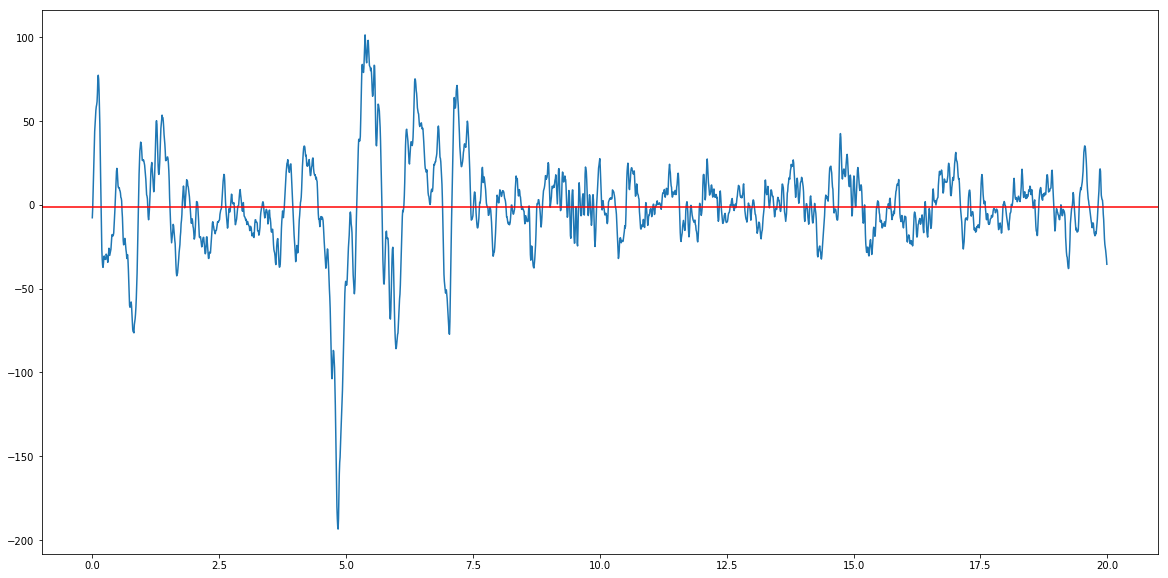

In [4]:
window = Fs*20
plt.figure(figsize=((20,10)))
plt.plot(t[:window], s[:window])
plt.axhline(np.mean(s[:window]), c='r')
plt.show()

### Pierwszy klasyfikator:

* filtruj sygnał filtrem pasmowo-przepustowym w paśmie 11-16 Hz
* przefiltrowany sygnał podnieś do kwadratu i przefiltruj filtrem dolnoprzepustowym z częstością odcięcia 10 Hz
* spierwiastkuj uzyskany sygnał
* wyszukaj momenty, w których sygnał ten przekracza wartość 5 mikroVoltów na okresy dłuższe niż 0.5 s.
* te okresy to wyszukane tą techniką wrzeciona

In [5]:
N = 7
Wn = (11/nyq_f, 16/nyq_f)
[b,a] = ss.butter(N, Wn, btype='bandpass')

In [6]:
s_1 = ss.filtfilt(b,a,s)
s_1 *= s_1

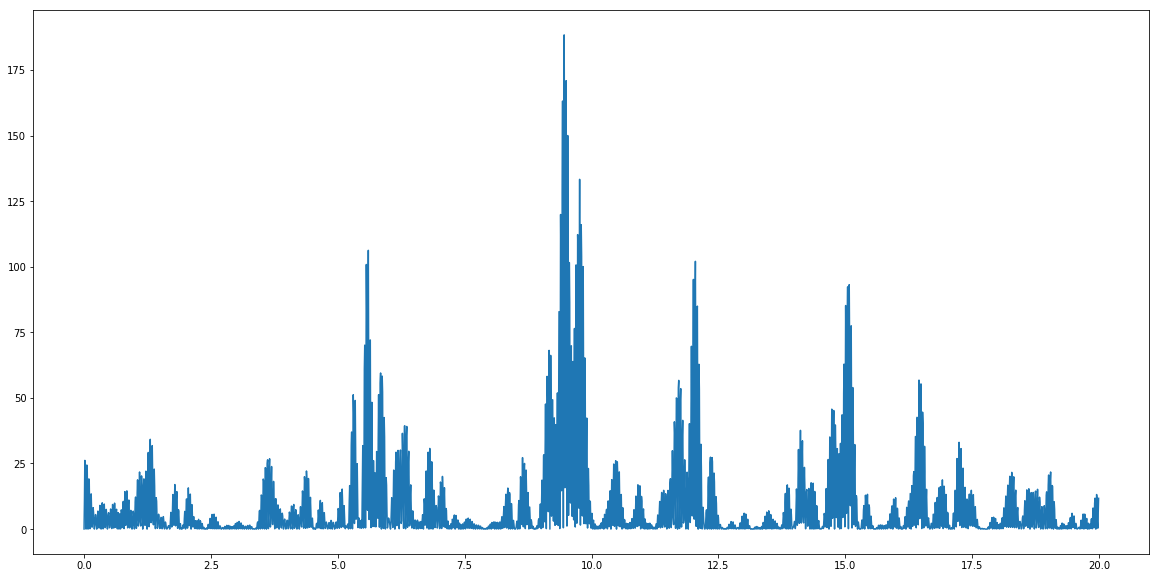

In [7]:
plt.figure(figsize=((20,10)))
plt.plot(t[:window], s_1[:window])
plt.show()

In [8]:
N = 7
Wn = 10/nyq_f
[b,a] = ss.butter(N, Wn, btype='lowpass')

In [9]:
s_2 = ss.filtfilt(b,a,s_1)
s_2 = s_2 ** .5

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


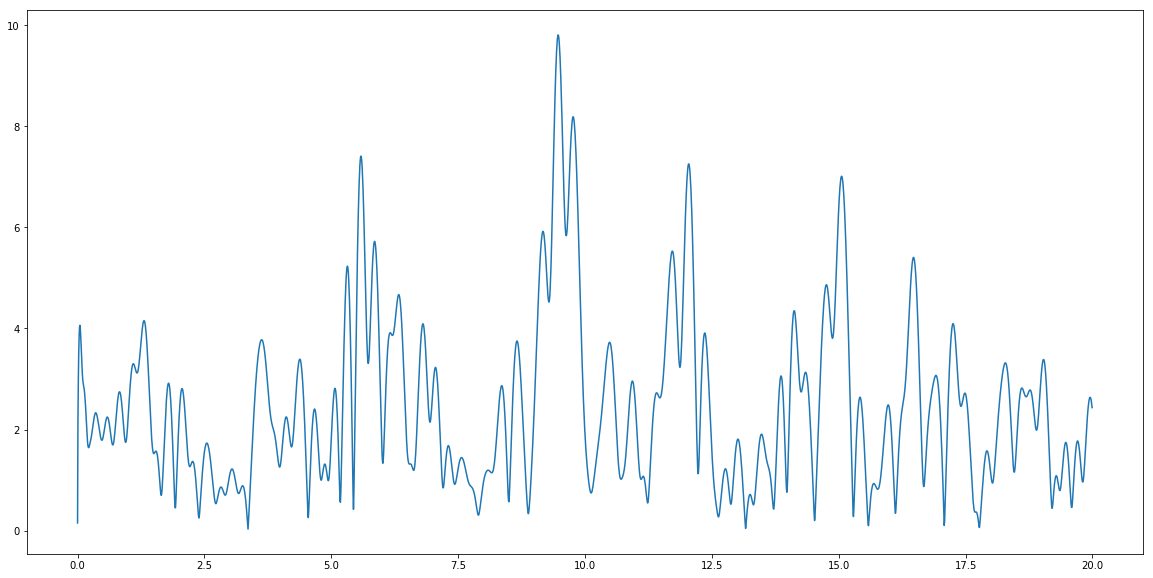

In [10]:
plt.figure(figsize=((20,10)))
plt.plot(t[:window], s_2[:window])
plt.show()

In [11]:
s_2[s_2 < 5] = 0
s_2[s_2 >= 5] = 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


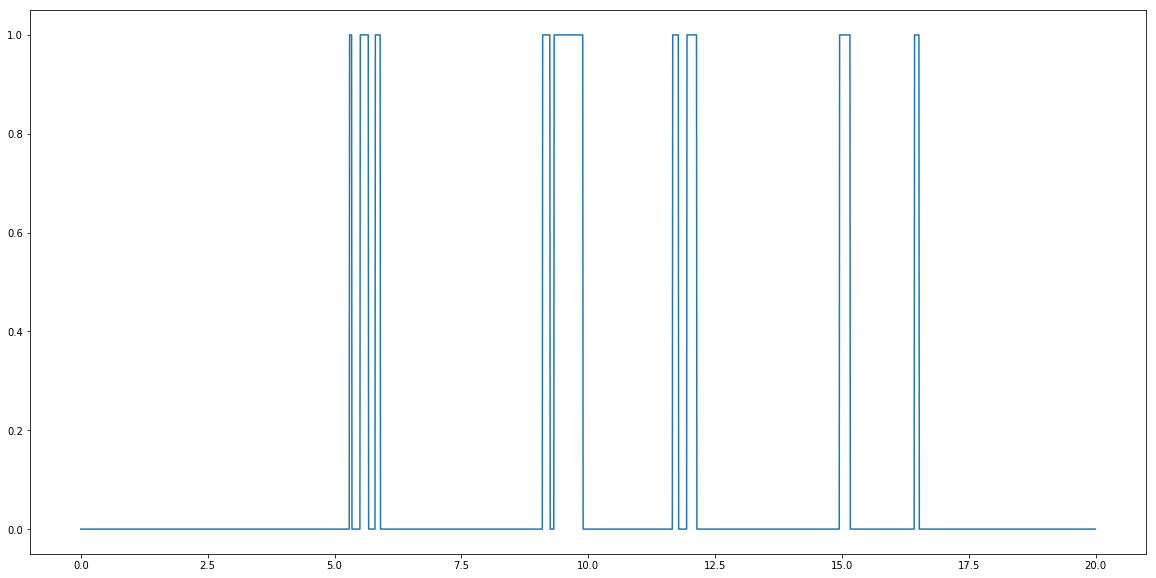

In [12]:
plt.figure(figsize=((20,10)))
plt.plot(t[:window], s_2[:window])
plt.show()

In [13]:
min_t = 0.5
min_elements = int(min_t * Fs)

length = len(s_2) - min_elements
spindle = []
for i in range(0, length):
    total = np.sum(s_2[i:i+min_elements])
    ratio = total/min_elements
    if ratio == 1:
        spindle.append(i)

In [14]:
prev = spindle[0]
filt_spindles = [spindle[0]]
for w in spindle:
    if w - prev > 1:
        filt_spindles.append(prev + min_elements - 1)
        filt_spindles.append(w)
    prev = w
filt_spindles.append(spindle[-1] + min_elements - 1)
filt_spindles = np.array(filt_spindles)
shape = filt_spindles.shape[0]
filt_spindles = filt_spindles.reshape(int(shape/2), 2)
print(filt_spindles)
# the array has at pointer 0 the start point and pointer 1 the end point

[[ 1194  1266]
 [13110 13175]
 [15165 15252]
 [16711 16790]
 [28392 28456]
 [30003 30066]
 [39280 39391]
 [42359 42448]
 [45149 45256]
 [45583 45661]
 [45898 45999]
 [47190 47257]
 [48931 49043]
 [49931 49995]
 [50608 50678]
 [54439 54519]
 [58598 58665]
 [62708 62779]
 [64466 64534]
 [65056 65119]
 [69362 69430]
 [70679 70750]
 [74835 74944]]


In [15]:
# Transform to time
filt_spindles = filt_spindles / Fs
print(np.round(filt_spindles, 2)) # [t_start, t_end]

[[  9.33   9.89]
 [102.42 102.93]
 [118.48 119.16]
 [130.55 131.17]
 [221.81 222.31]
 [234.4  234.89]
 [306.88 307.74]
 [330.93 331.62]
 [352.73 353.56]
 [356.12 356.73]
 [358.58 359.37]
 [368.67 369.2 ]
 [382.27 383.15]
 [390.09 390.59]
 [395.38 395.92]
 [425.3  425.93]
 [457.8  458.32]
 [489.91 490.46]
 [503.64 504.17]
 [508.25 508.74]
 [541.89 542.42]
 [552.18 552.73]
 [584.65 585.5 ]]


In [16]:
print("Liczba znalezionych wrzecion:", len(array))

NameError: name 'array' is not defined

## Drugi klasyfikator

* wykonaj dekompozycję MP sygnału dzielonego na 20 sek. epoki (30 epok). Więcej o dekompozycji MP w [2].
* wykonaj ją dla dwóch wartości parametrów 'energyError' = {0.1, 0.01}
* wymuś 50 iteracji na epokę
* wykonaj mapy czas-częstość na podstawie uzyskanych dekompozycji
* przeglądajac parametry atomów, wyszukaj te, które spełniają defnicję wrzeciona (częstość z przedziału 11-16 Hz, czas trwania>0.5 s).

In [17]:
def TFRPlot(TFR, t_mapy, f_mapy, sig, Fs=128,title =''):
    '''
    Funkcja do rysowania map czas-częstość z sygnałem zaprezentowanym poniżej
    TFR - mapa czas-częstość (time-freqyency representation
    t_mapy, f_mapy - wektory reprezentujące osie czasu i częstości
    sig - sygnał do wyrysowania pod mapą (np. ten, z którego powstała mapa)
    Fs - częstość próbkowania sygnału 
    title - tytuł do wyświetlenia ponad mapą
    '''
    df = f_mapy[1]-f_mapy[0]
    dt = t_mapy[1]-t_mapy[0]
#     t = np.arange(0,len(sig))/Fs
    t = t_mapy
    plt.figure(figsize=(20,5))
    sygAxes = plt.axes([0.05, 0.05, 0.8, 0.1])
    tfAxes = plt.axes([0.05, 0.15, 0.8, 0.8])
    sygAxes.plot(t,sig)
    plt.xlim((t_mapy.min(), t_mapy.max()))
    #py.setp(sygAxes, yticklabels=[])
    tfAxes.imshow(TFR,aspect='auto',origin='lower',interpolation='nearest', 
                  extent=(t_mapy.min()-dt/2,t_mapy.max()+dt/2,f_mapy.min()-df/2,f_mapy.max()+df/2))
    plt.setp(tfAxes,xticklabels=[])
    plt.title(title)
    plt.show()


In [18]:
# Najpierw ustawiamy zmienne zgodnie z naszymi potrzebami

PlikSygnalu = './inb14_fragment.bin' # tu jeśli nie jest to plik w bieżącym katalogu 
                             # to trzeba podać pełną ścieżkę dostępu
PlikKonfigu = './inb14_fragment.set'

Fs = 128            # częstość próbkowania [Hz]
liczbaProbek_w_Epoce = 128*20   # na sztuki, istotna jeśli chcemy długi sygnał rozkładać w krótszych fragmentach, 
                             # odpowiadających np. realizacji eksperymentu
liczbaKanalow = 1            # liczba kanłów = K z powyższego opisu o 
                             # przygotowaniu sygnału
wybraneKanaly = 1            # wybrane kanały: 
                             #     a) numerowane są od 1
                             #     b) składnia wybierania: 1, 3, 5, 7-11, 19
wybraneEpoki = '1-30'            # które epoki analizować, składnia wyboru tak jak dla kanałów
 
maxIteracji = 50            # liczba iteracji do wykonania dla jednej epoki, chyba, 
                             # że wcześniej zostanie osiągnięty zadany poniżej                     
procentEnergii = 95.        # procent wyjaśnionej energii
energyError    = 0.1        # parametr regulujący gęstość słownika float w zakresie 0-1. 
                            # odpowiada minimalnej odległości między atomami słownika mierzonej w metryce iloczynów skalarnych
                            # nierówności (7) w cytowanym art. 
                            # Czym mniejszy tym większy słownik i tym dokładniejsza dekompozycja 
algorytm = 'SMP'            # możliwe wartości SMP | MMP1 |MMP2 |MMP3 - algorytmy opisane w art.


# powyższe ustawiena zapisujemy do pliku tekstowego:
fo = open(PlikKonfigu, "wt")
fo.write( '# OBLIGATORY PARAMETERS\n')
fo.write( 'nameOfDataFile  ' + PlikSygnalu + '\n')
fo.write( 'nameOfOutputDirectory  ./\n')
fo.write( 'writingMode            CREATE \n') # 
fo.write( 'samplingFrequency      ' + str(Fs)+ '\n')
fo.write( 'numberOfChannels       ' + str(liczbaKanalow) + '\n')
fo.write( 'selectedChannels       ' + str(wybraneKanaly) + '\n')
fo.write( 'numberOfSamplesInEpoch ' + str(liczbaProbek_w_Epoce)+ '\n')
fo.write( 'selectedEpochs         ' + str(wybraneEpoki) + '\n')
fo.write( 'typeOfDictionary       OCTAVE_FIXED\n')
fo.write( 'energyError            ' + str(energyError)+' 100.0 \n')
fo.write( 'randomSeed             auto \n')
fo.write( 'reinitDictionary       NO_REINIT_AT_ALL \n')
fo.write( 'maximalNumberOfIterations ' +str(maxIteracji)+ '\n')
fo.write( 'energyPercent             ' +str(procentEnergii)+ '\n')
fo.write( 'MP                        ' + algorytm + '\n')
fo.write( 'scaleToPeriodFactor       1.0 \n')
fo.write( 'pointsPerMicrovolt        1.0 \n')

fo.write( '\n# ADDITIONAL PARAMETERS\n')
fo.write( 'normType                  L2 \n') 
fo.write( 'diracInDictionary         YES \n') # ta i poniższe linie włączają odpowiednie typy funkcji do słownika
fo.write( 'gaussInDictionary         YES \n')
fo.write( 'sinCosInDictionary        YES \n')
fo.write( 'gaborInDictionary         YES \n')
fo.close()

In [19]:
import os
os.system('./empi-osx64 ' + PlikKonfigu)

0

In [151]:
def parametry_atomu(book, atom):
    f_Hz  = atom['params']['f']*book.fs/2     # przekodowujemy częstość atomu na częstość w Hz
    A     = atom['params']['amplitude']        # odczytujemy amplitudę
    faza  = atom['params']['phase']            # odczytujemy fazę
    t0    = atom['params']['t']/book.fs      # przeliczamy pozycję atomu z wartości w próbkach na wartości w sek.
    skala = atom['params']['scale']/book.fs   # szerokość atomu w czasie (w sek.)
    return f_Hz, A, faza, t0, skala  

def tfr_atomu (book, atom, N_czestosci):
    f_Hz, A, faza, t0, skala = parametry_atomu(book, atom)
    t = np.arange(0,book.epoch_s/book.fs,1/book.fs)
    f = np.linspace(0, Fs / 2, N_czestosci)
    rec_t = np.zeros((1,book.epoch_s))
    rec_f = np.zeros((N_czestosci,1))
    rec_t[0,:] = np.exp(-np.pi*((t-t0)/skala)**2)      # obliczamy obwiednię czasową -> dla f. Gabora jest to f. Gaussa
    print("f {}, f_Hz {}, skala {}".format(f, f_Hz, skala))
    rec_f[:,0] = np.exp(-np.pi*((f-f_Hz)*skala)**2)   # obliczamy obwiednię częstotliwościową -> dla f. Gabora jest to f. Gaussa
    tfr_atom = np.kron(rec_t,rec_f) # przemnażamy przez siebie obwiednie -> to jest reprezentacja czas-częstość pojedynczego atomu
    tfr_atom/= np.sum(np.sum(tfr_atom))   # normalizujemy
    tfr_atom *= atom['params']['modulus']**2 # skalujemy energię
    return t, f, tfr_atom

def rekonstrukcja_atomu(book, atom):
    f_Hz, A, faza, t0, skala = parametry_atomu(book, atom)
    t = np.arange(0,book.epoch_s/book.fs,1/book.fs)     
    rekonstrukcja = A * np.exp(-np.pi*((t-t0)/skala)**2)*np.cos(2*np.pi*f_Hz*(t-t0)+faza) # obliczamy przebieg czasowy atomu (funkcja Gabora) i 
    return t, rekonstrukcja


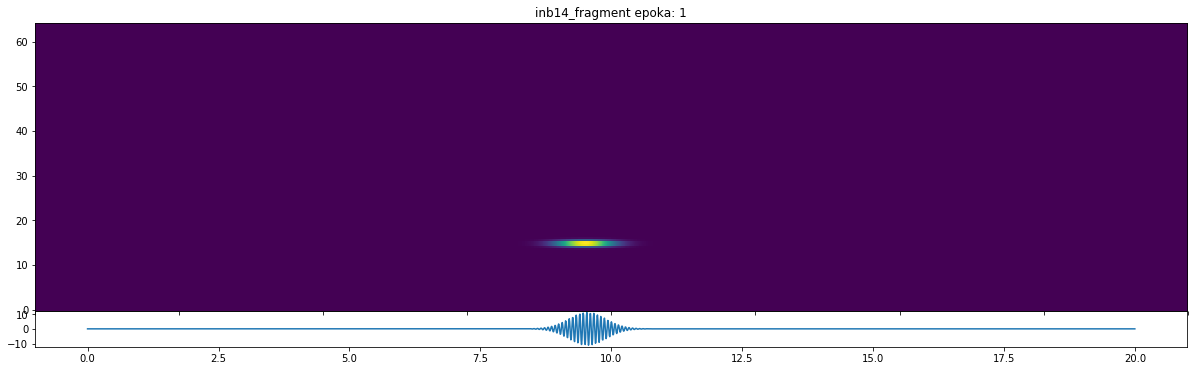

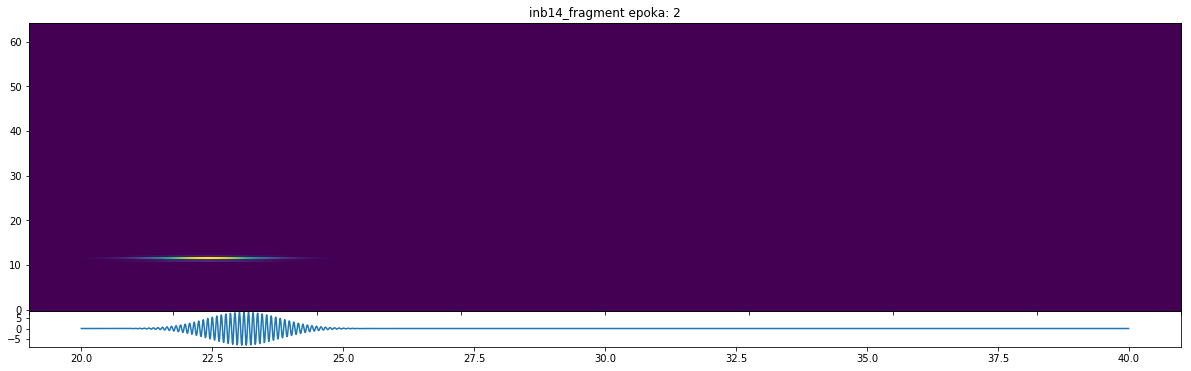

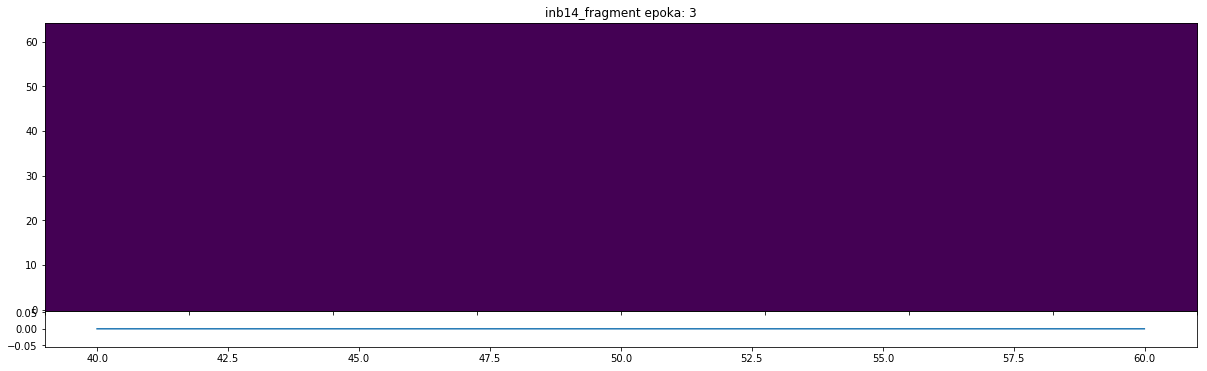

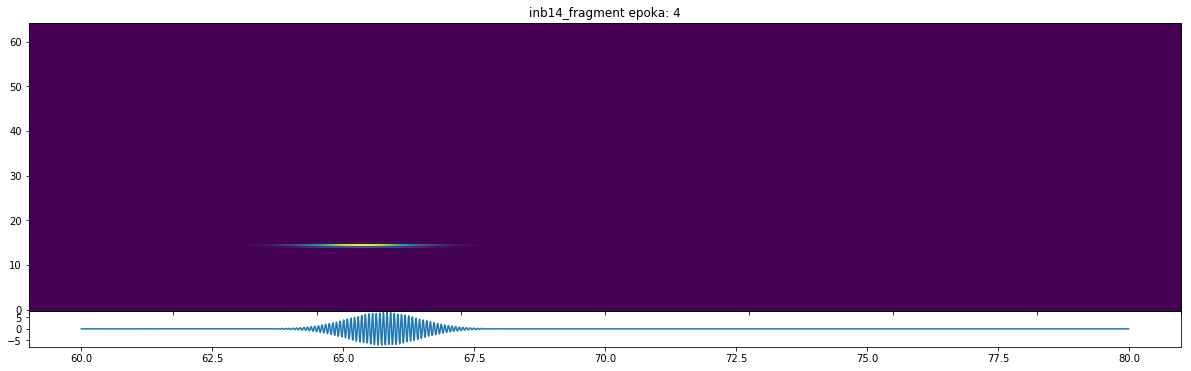

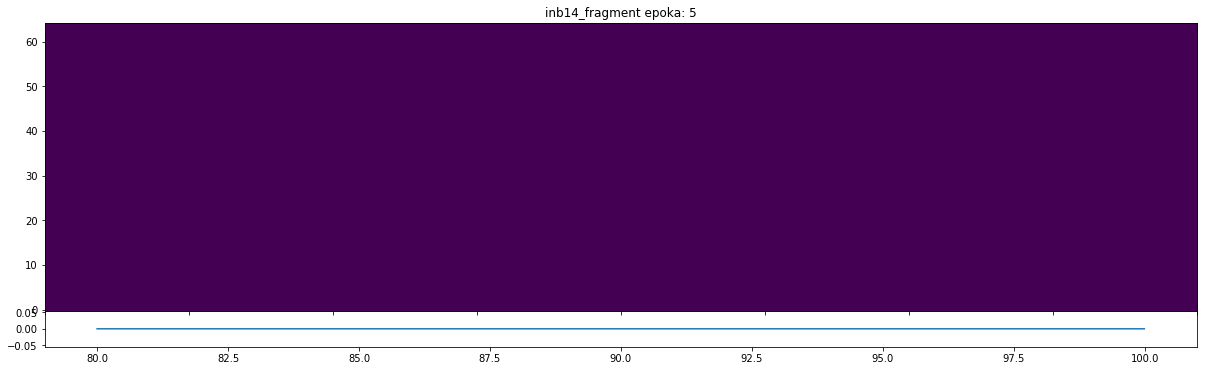

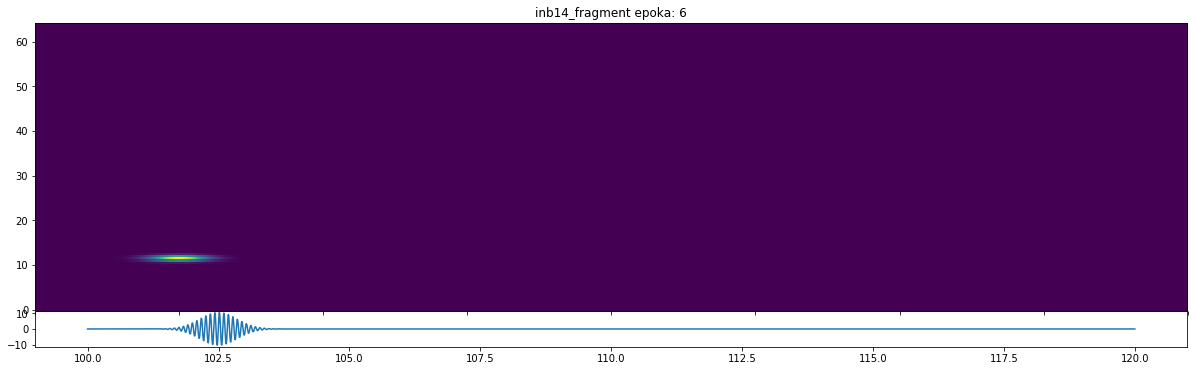

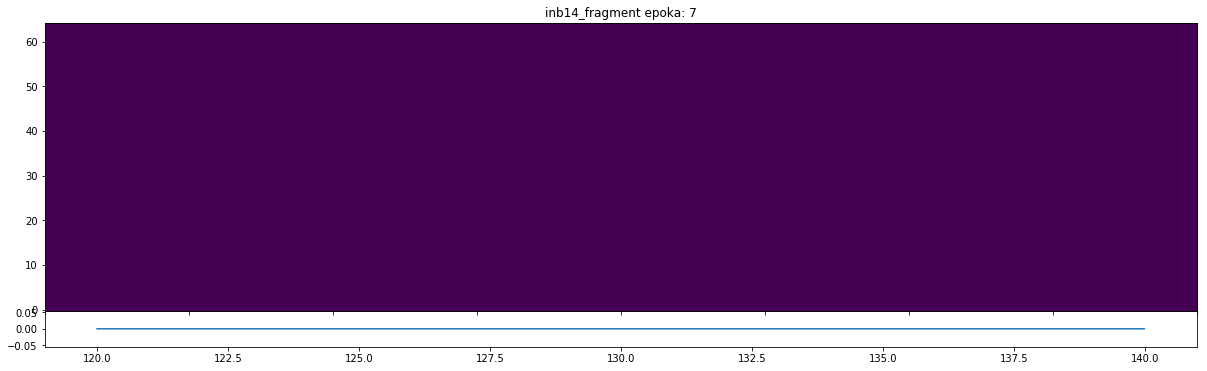

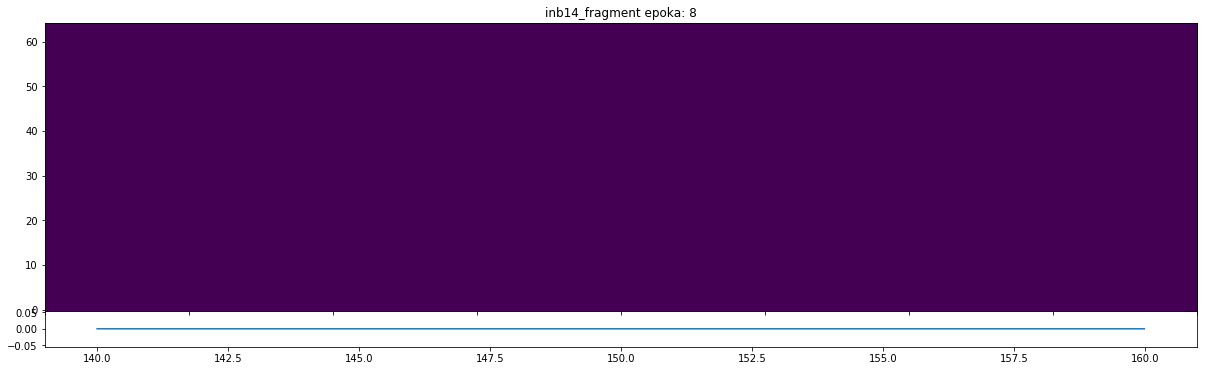

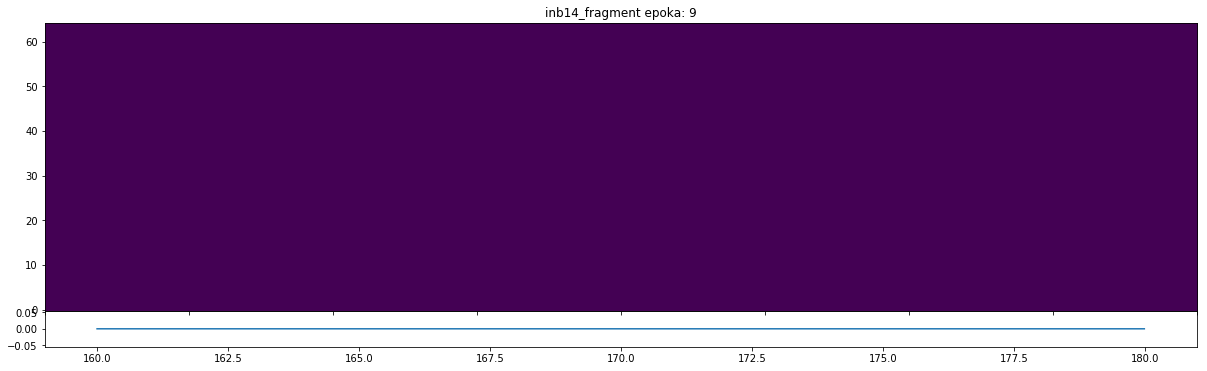

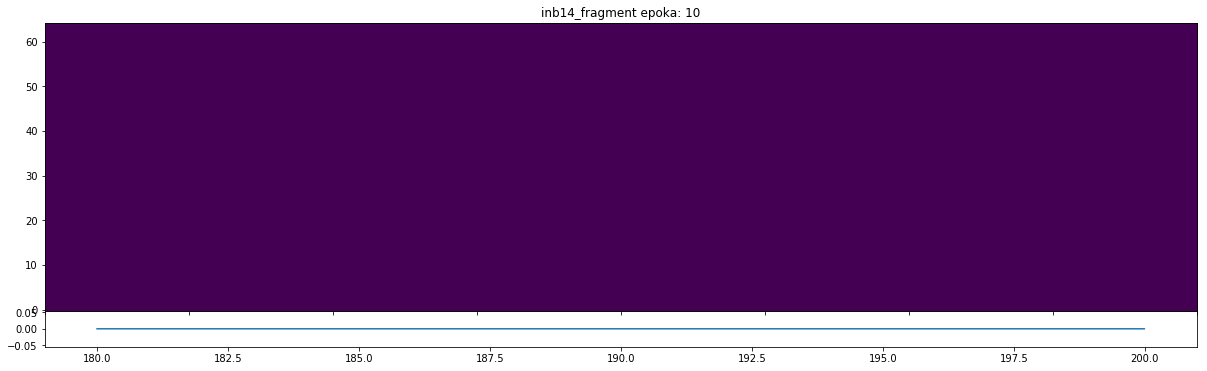

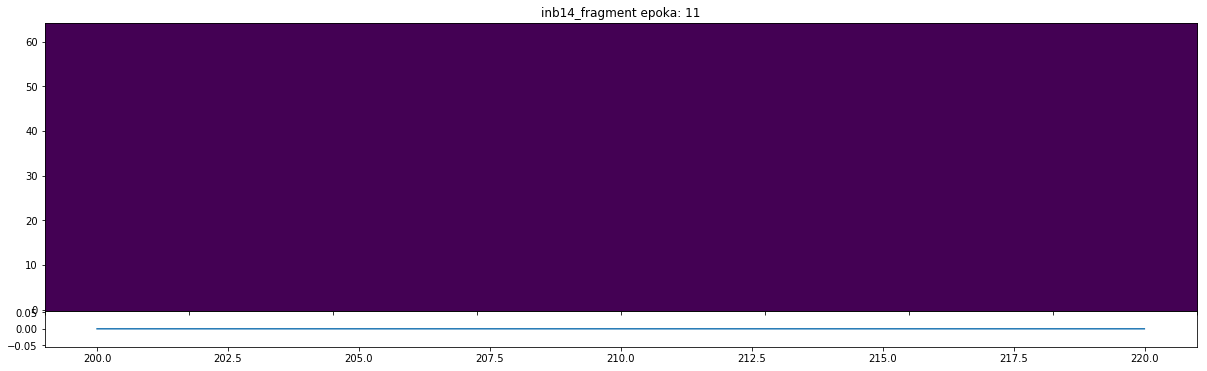

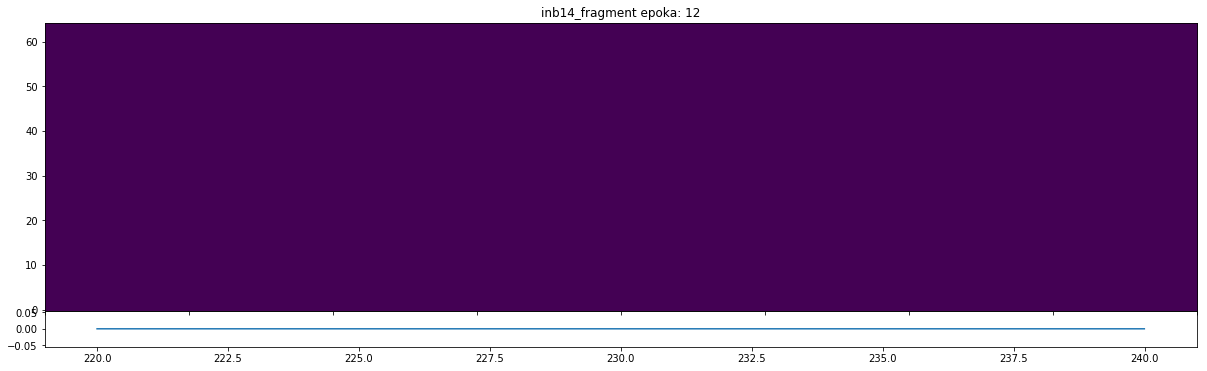

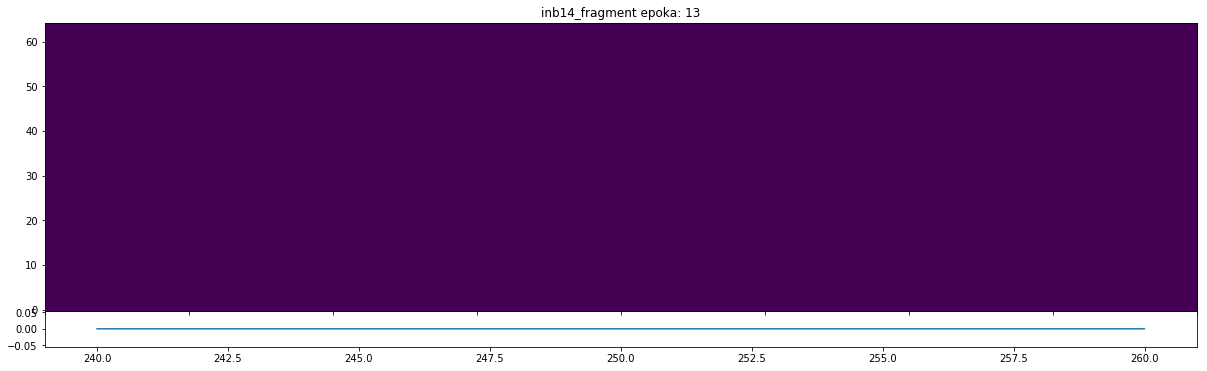

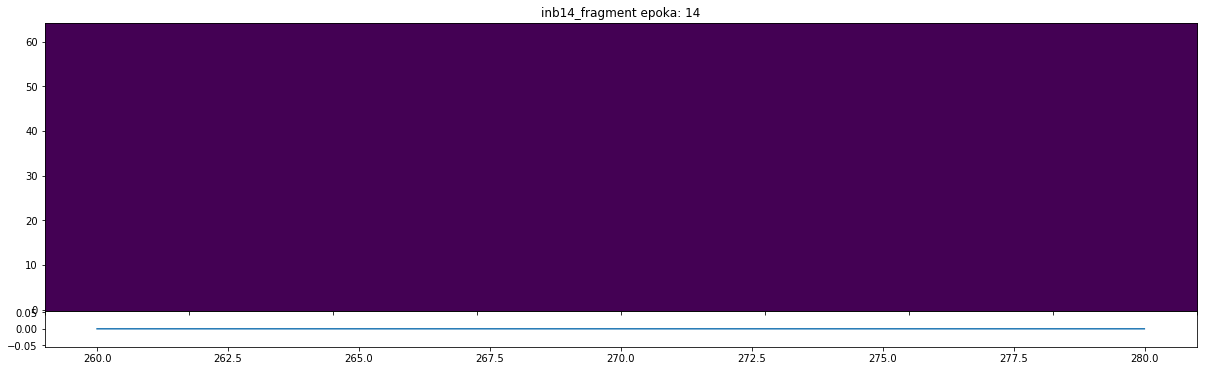

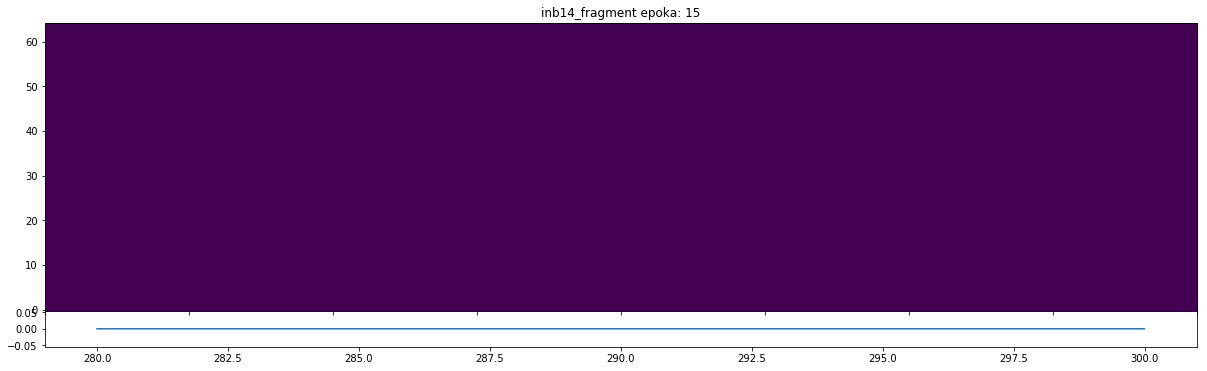

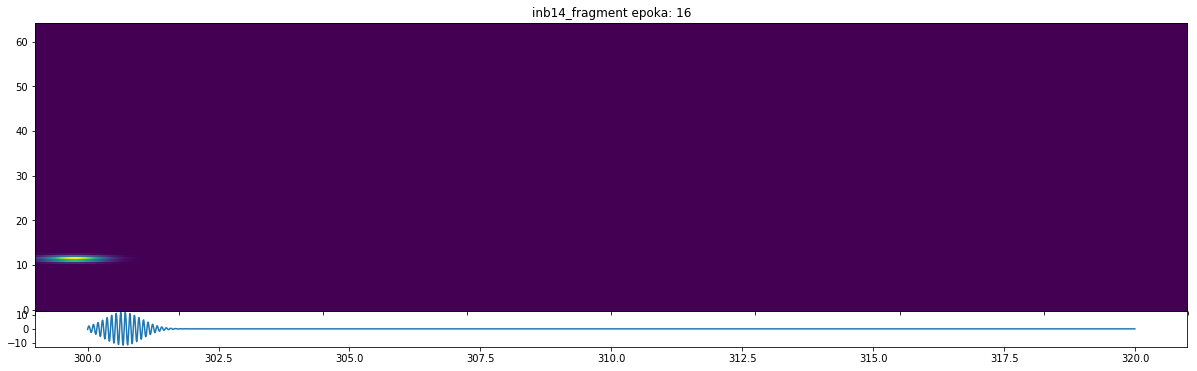

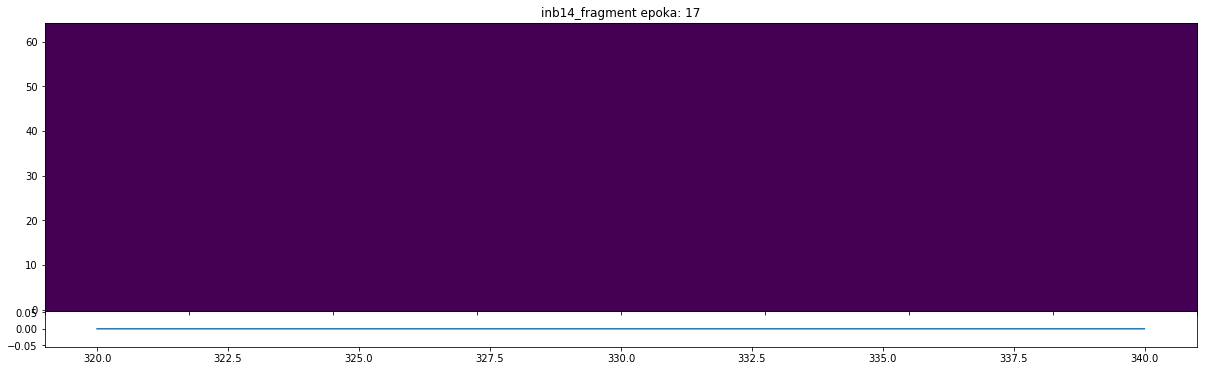

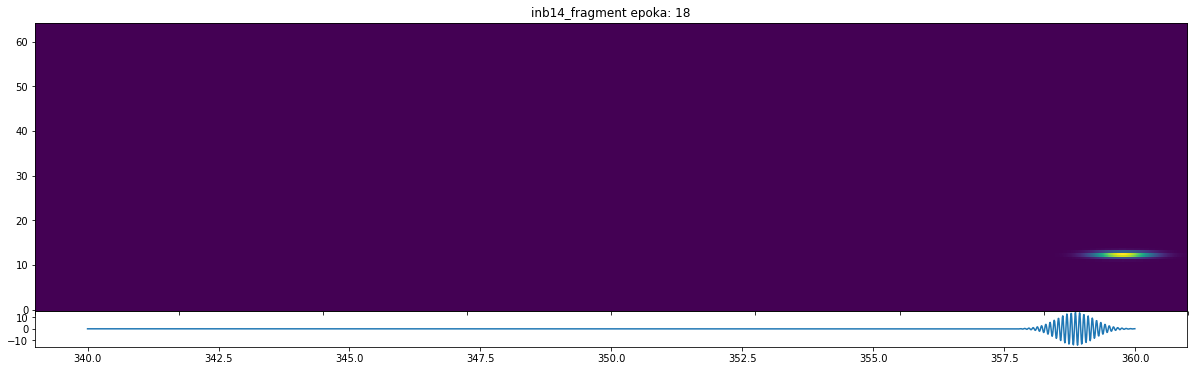

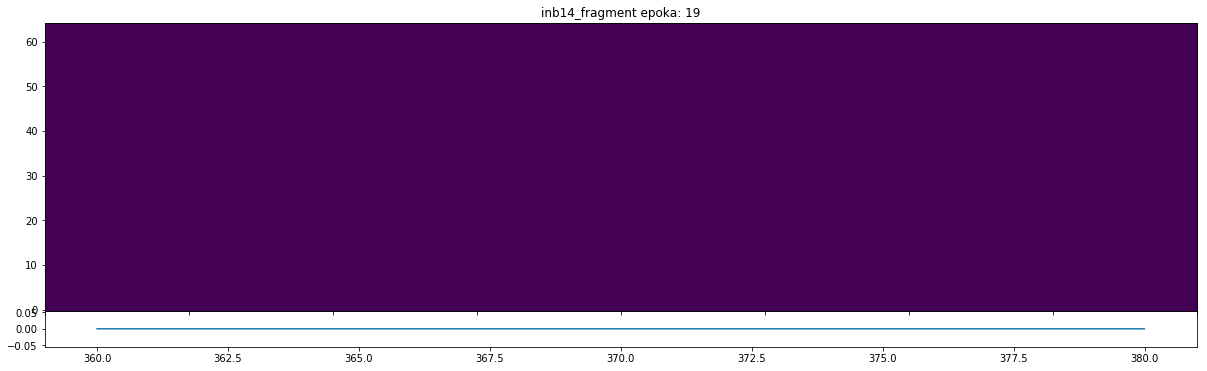

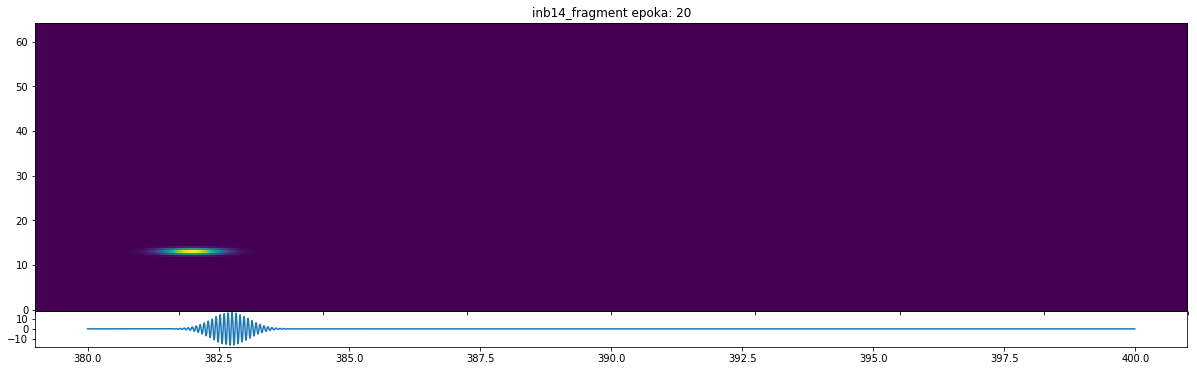

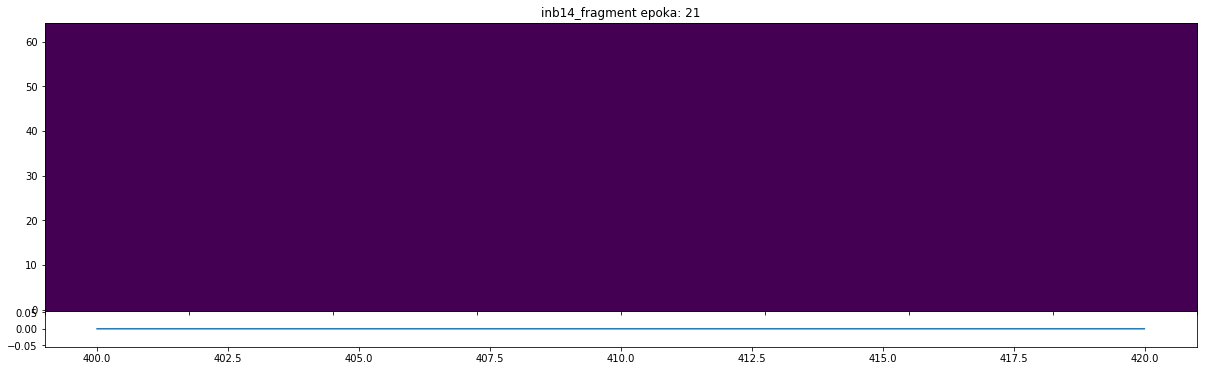

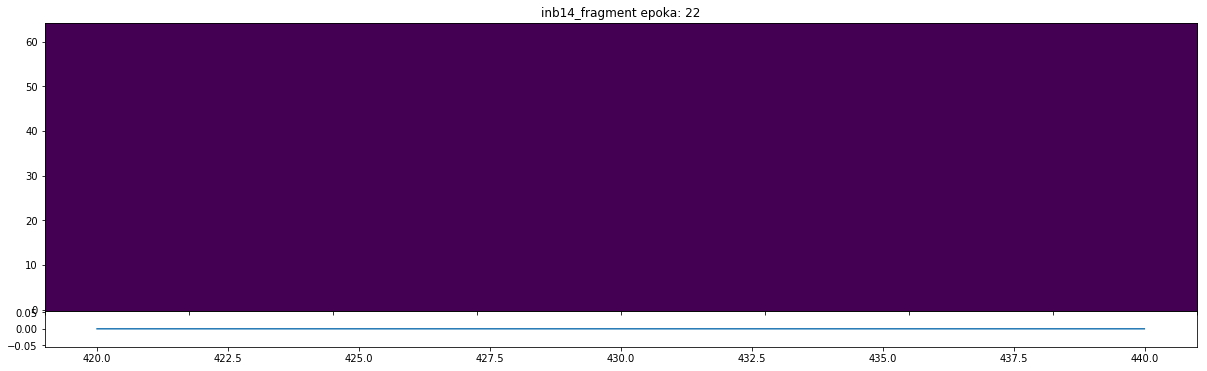

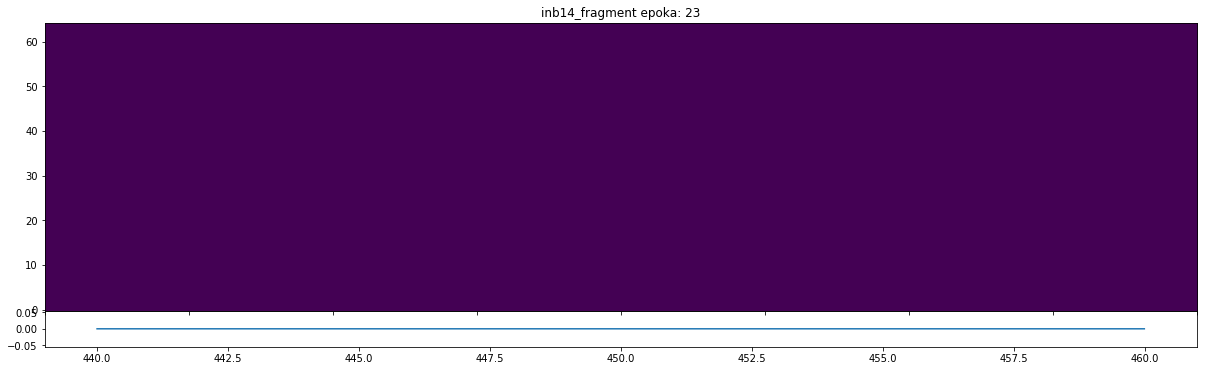

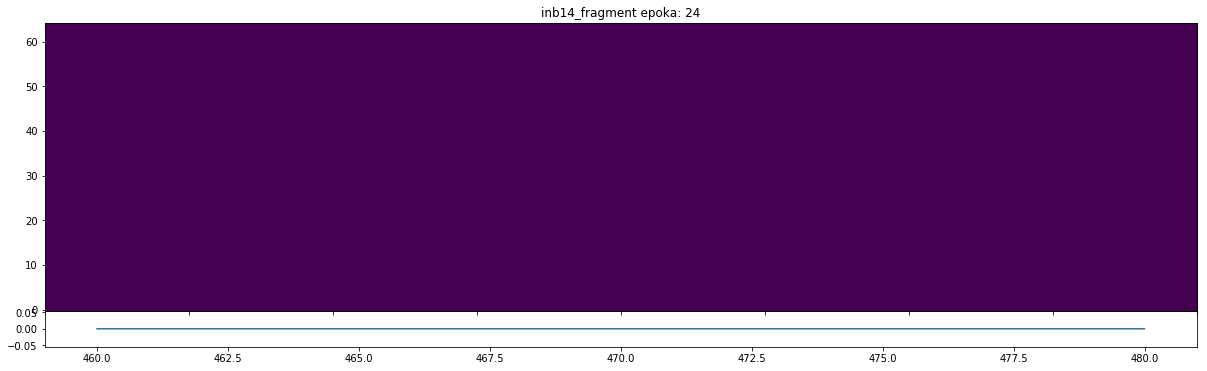

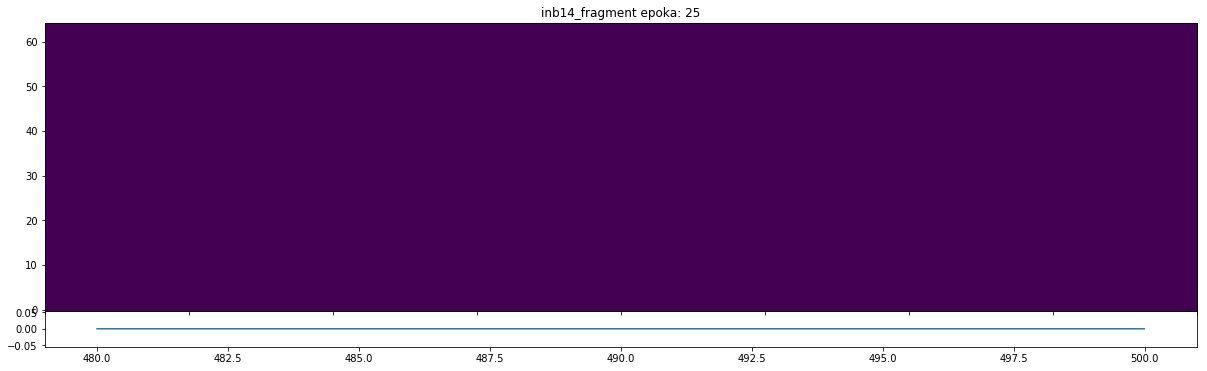

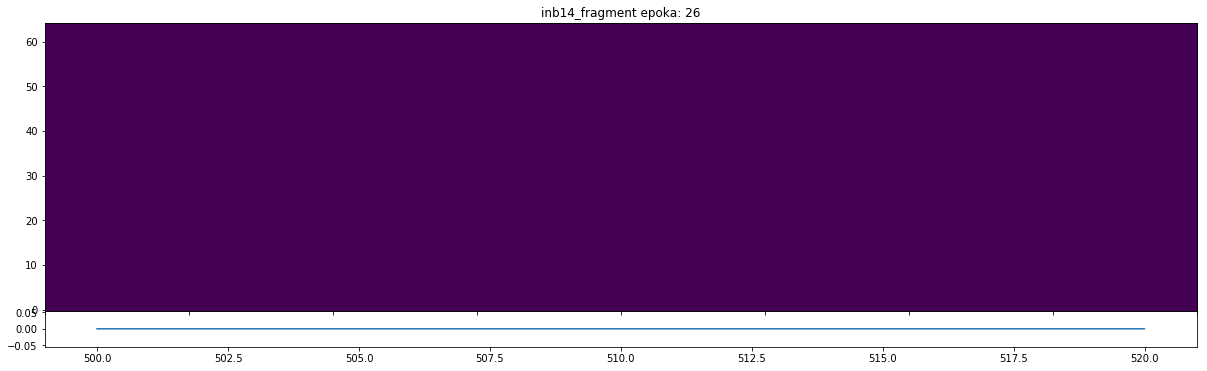

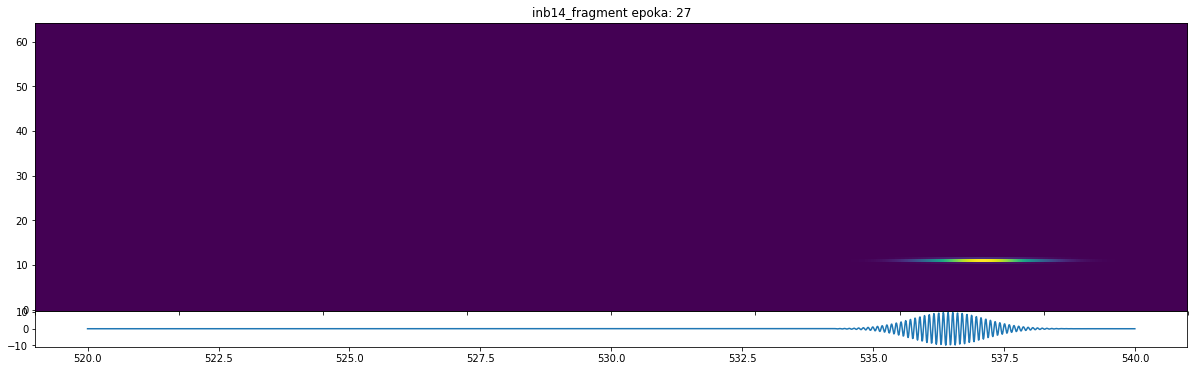

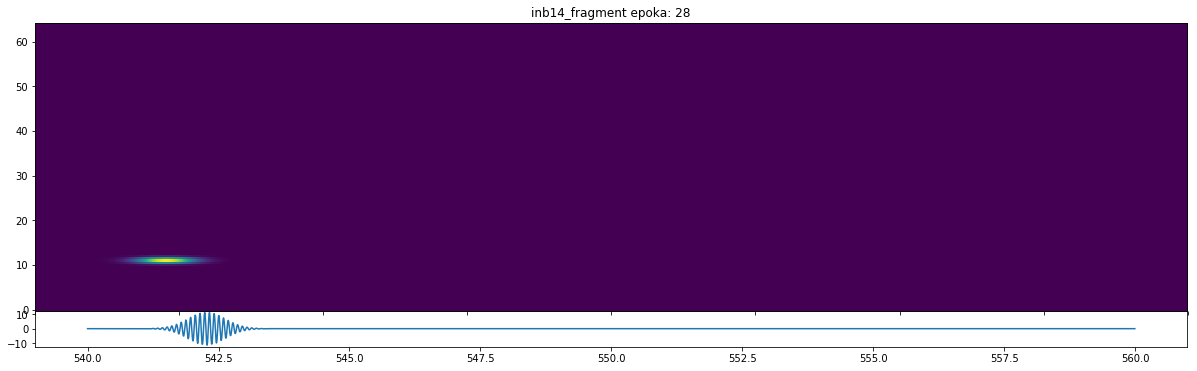

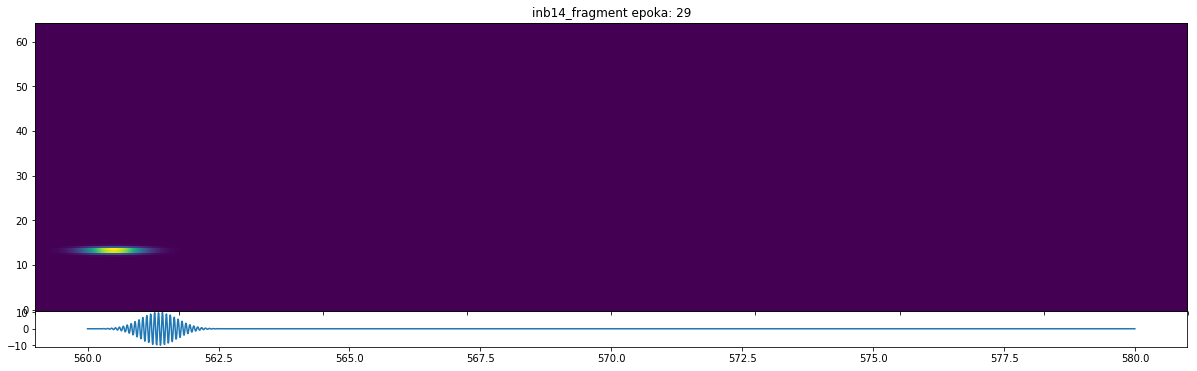

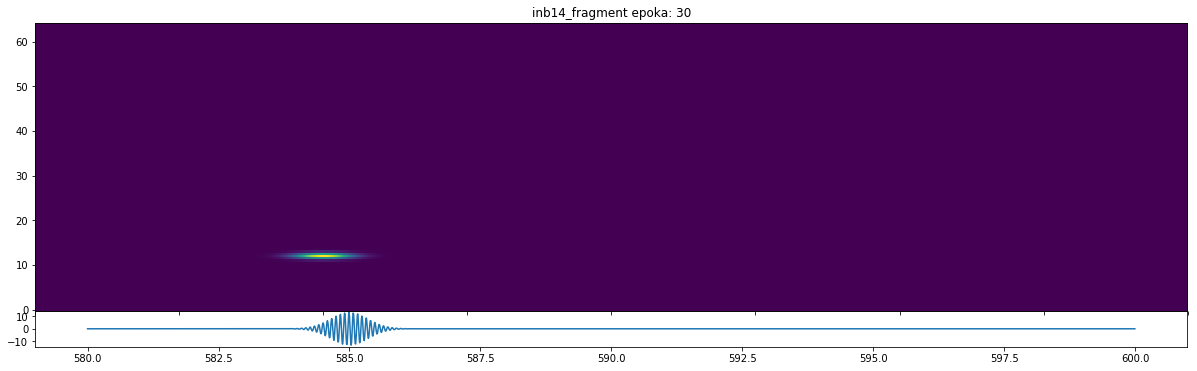

In [338]:
from book_reader import *
bookName = 'inb14_fragment_smp.b'
book = BookImporter(bookName)
N_czestosci = int(book.fs)
epoki = range(1,31)                                                # Posłuży on nam do odtwarzania poszczególnych atomów
total = 0
mp_spindles = []
for numerEpoki in epoki:
    rekonstrukcja = np.zeros(book.epoch_s) # Przygotowujemy tablicę, w której powstanie rekonstrukcja.
    mapaEnergii = np.zeros(( N_czestosci, book.epoch_s )) # Przygotowujemy tablicę, w której powstanie reprezentacja czas-częstość.
    for atom in book.atoms[numerEpoki]:     # iterujemy się po atomach danej epoki
        f_Hz, A, faza, t0, skala  = parametry_atomu(book, atom)
        t_mp, atom_czas = rekonstrukcja_atomu(book, atom)
        t_mp, f, atom_tfr = tfr_atomu (book, atom,N_czestosci)
        if f_Hz > 11 and f_Hz < 16 and skala >= 0.5:
            total += 1
            mapaEnergii += atom_tfr
            rekonstrukcja += atom_czas
            t_start = t0 + (numerEpoki-1)*20 - skala/2
            t_end = t0 + (numerEpoki-1)*20 + skala/2
            mp_spindles.append([t_start, t_end])
    1
    TFRPlot(mapaEnergii, t_mp, f, rekonstrukcja, Fs=128, title = "inb14_fragment epoka: {}".format(numerEpoki)) 

In [339]:
print("Liczba znalezionych wrzecion:", total)

Liczba znalezionych wrzecion: 11


## Porównanie Klasyfikatorów

Wpierw zostaną pokazane wszsystkie znalezione wrzeciona przez podane klasyfikatory

Legend
GREEN - Spindles found by MP 
RED - Spindles found through filtering


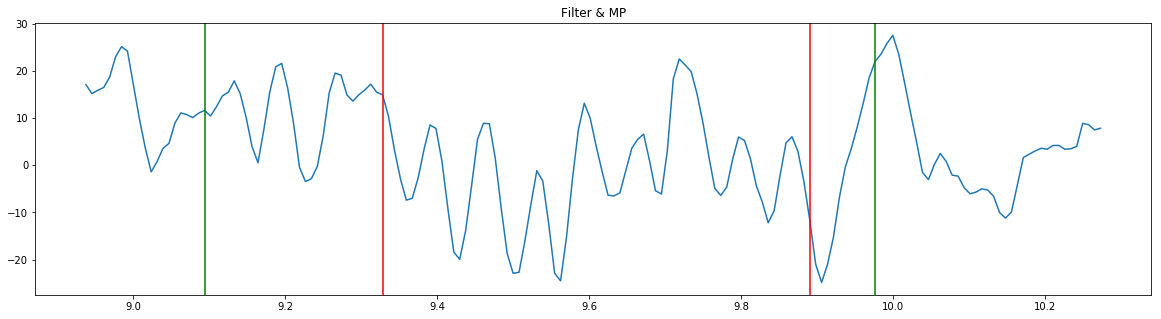

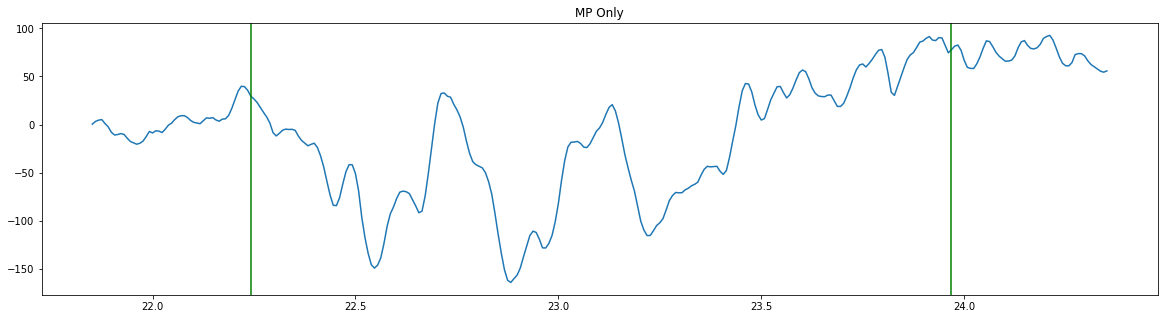

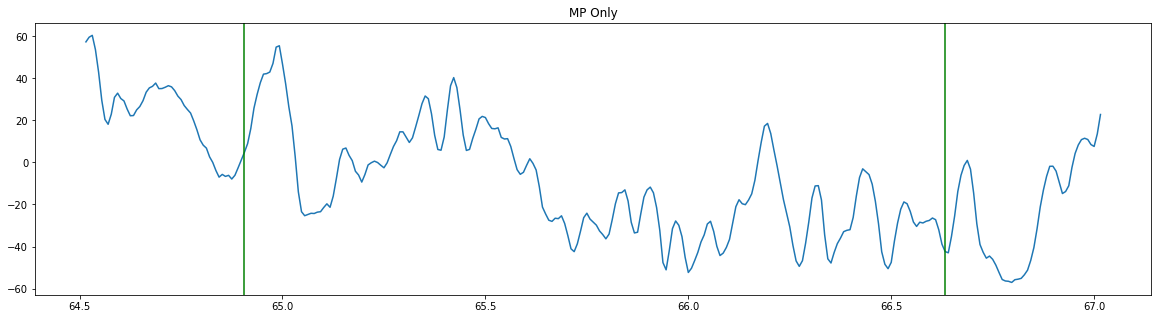

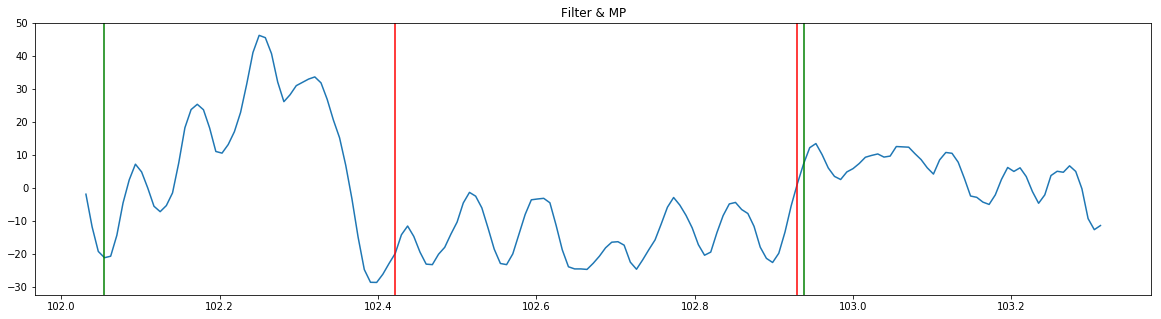

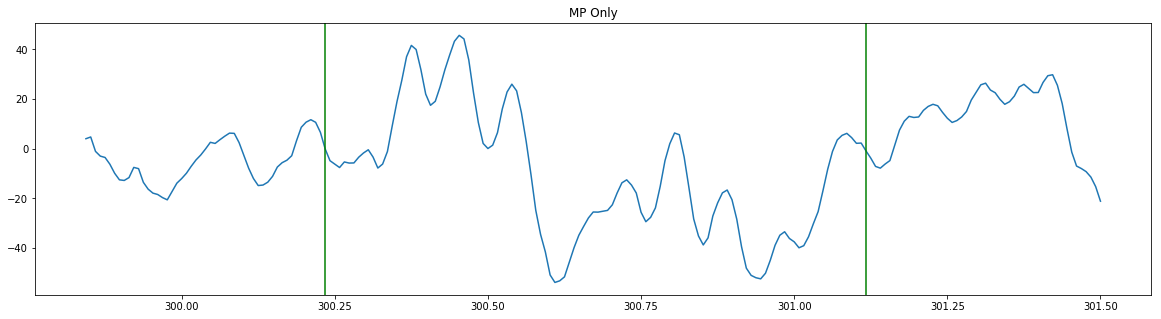

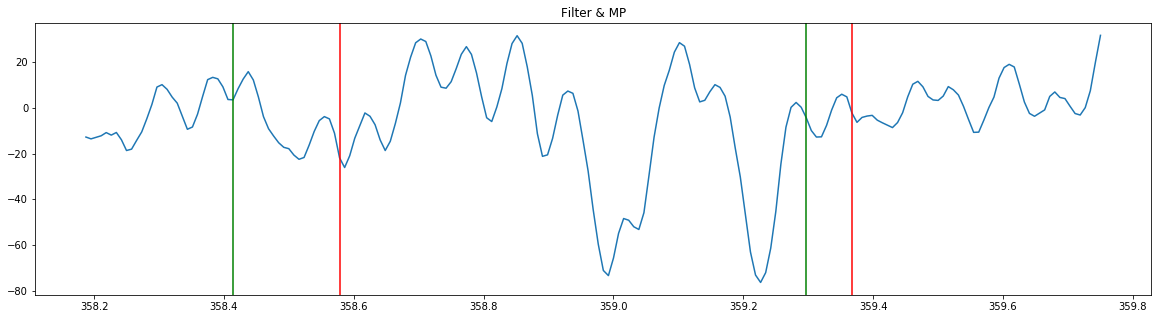

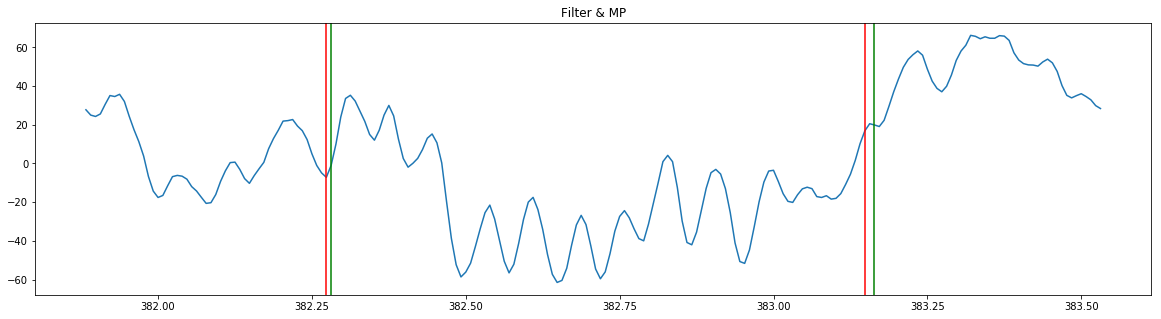

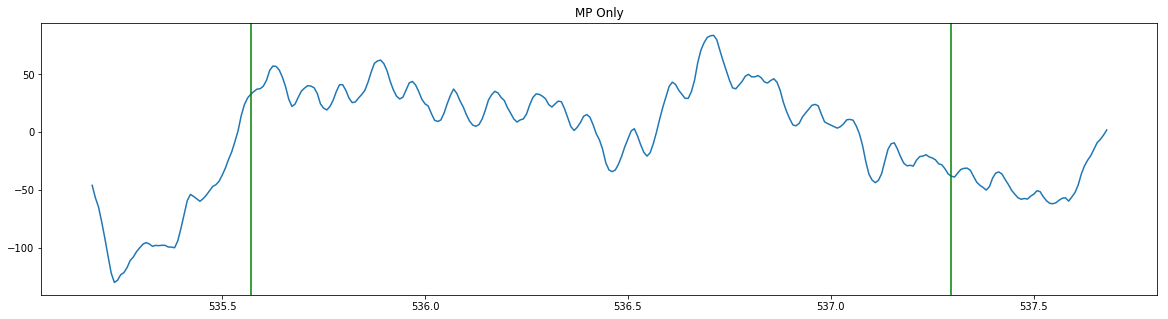

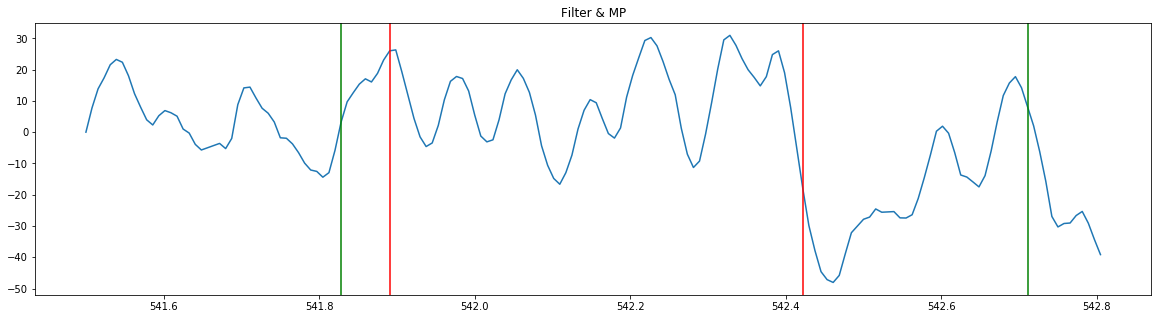

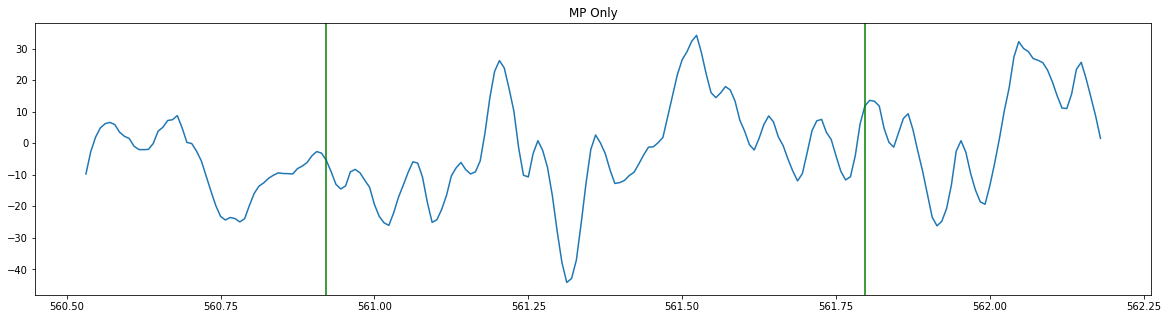

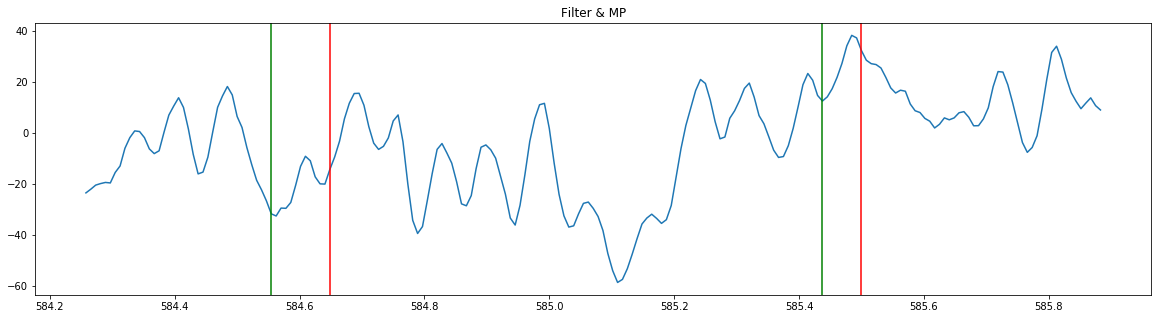

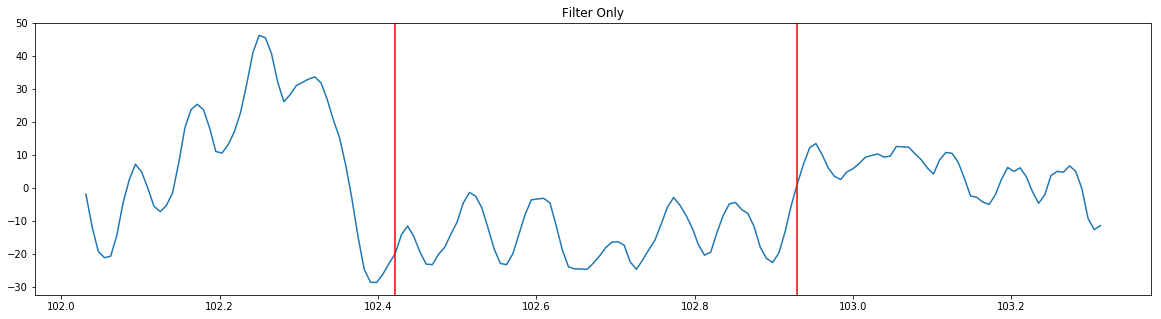

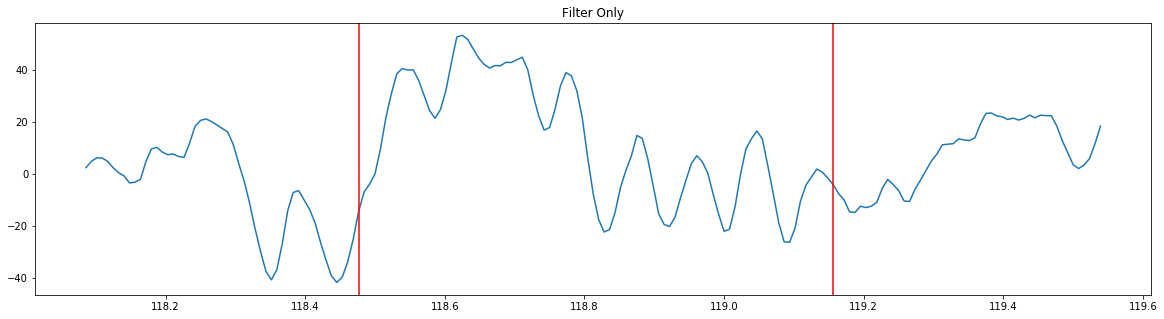

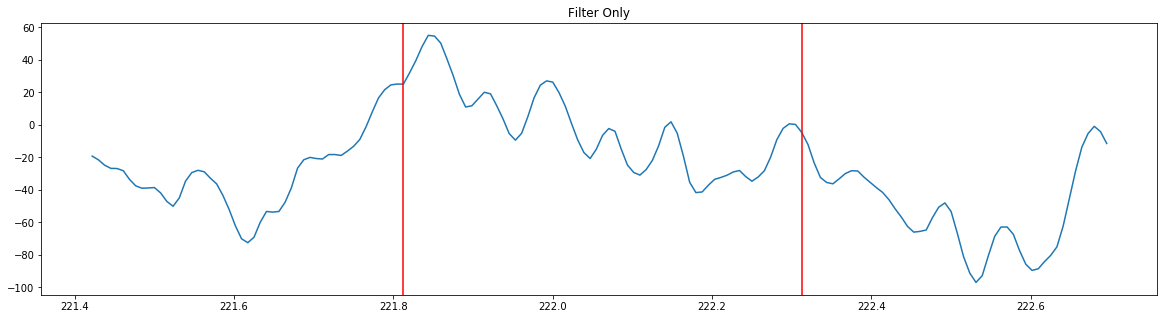

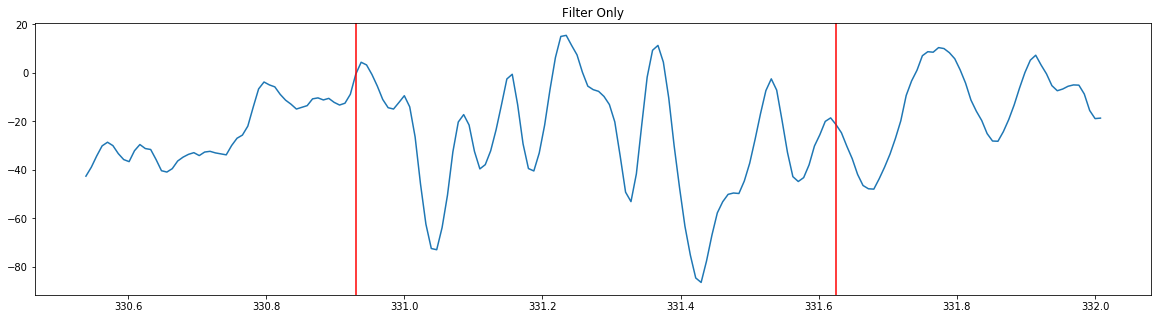

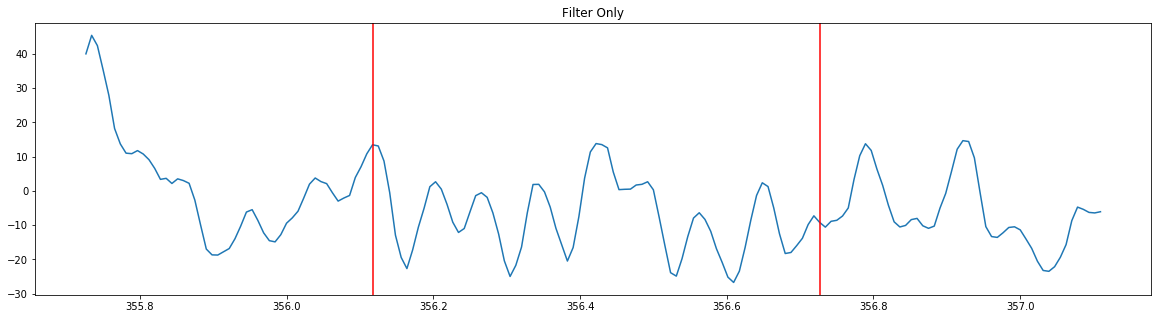

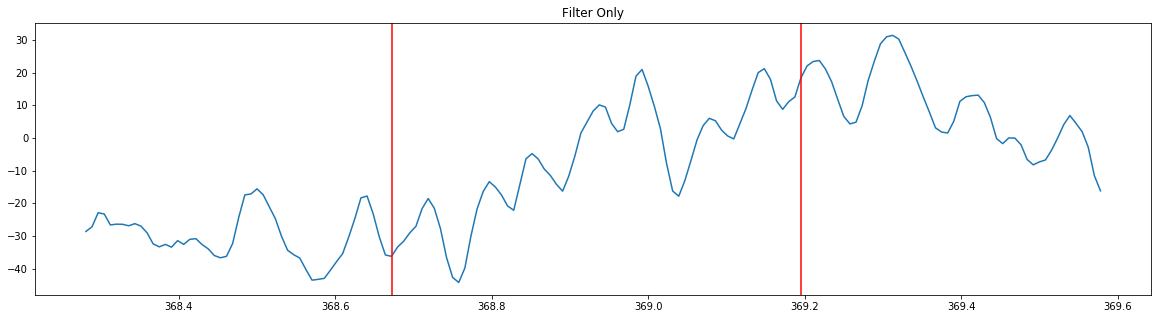

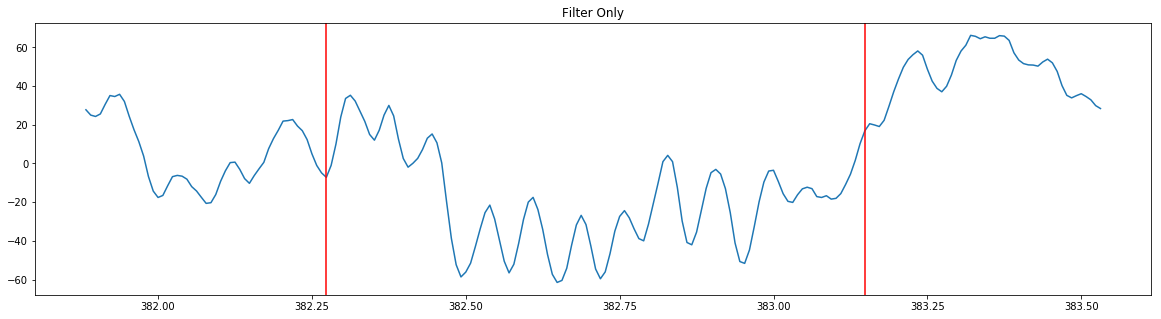

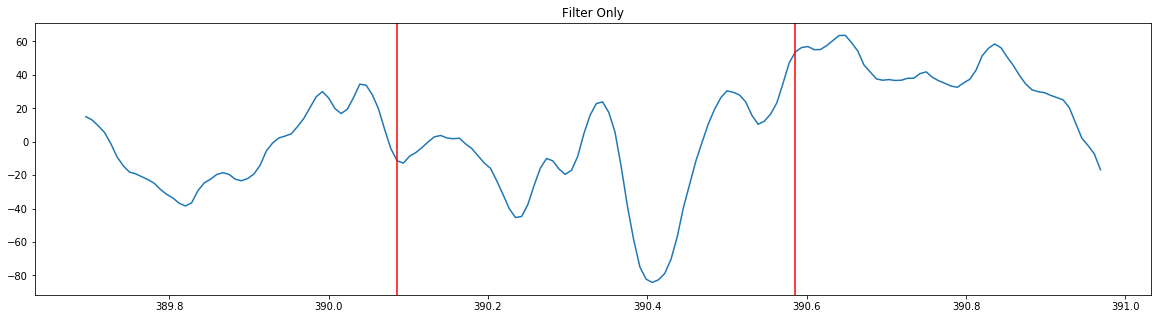

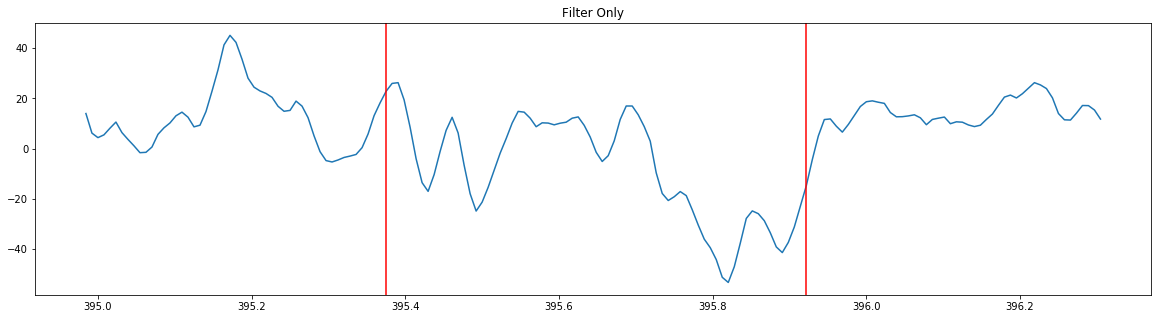

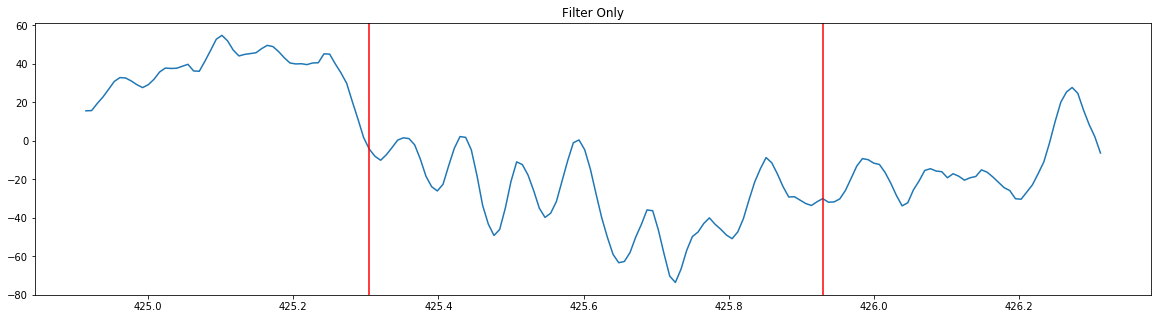

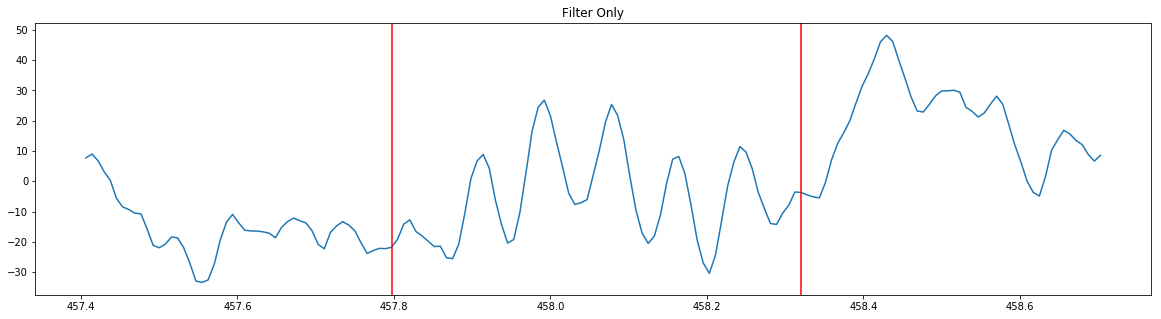

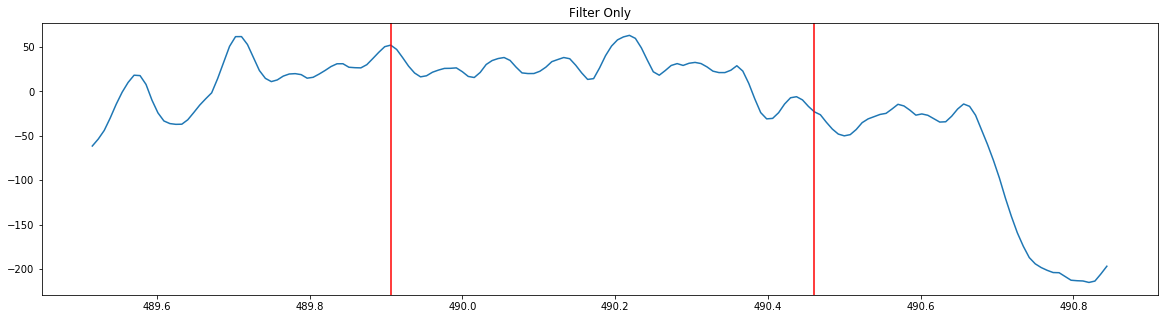

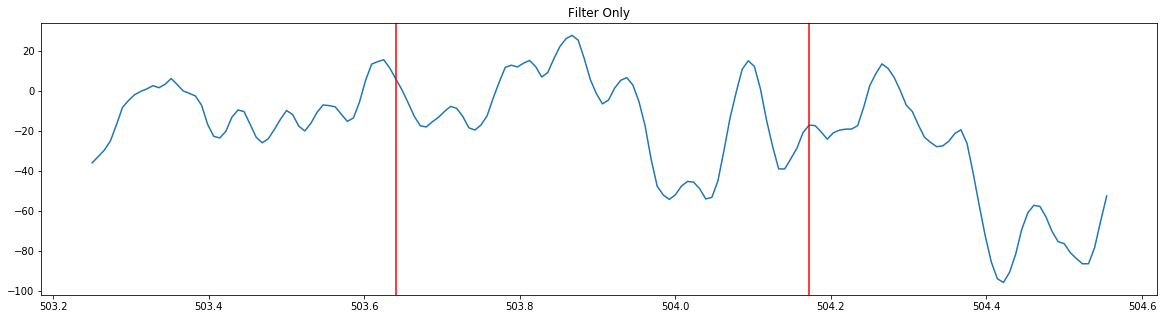

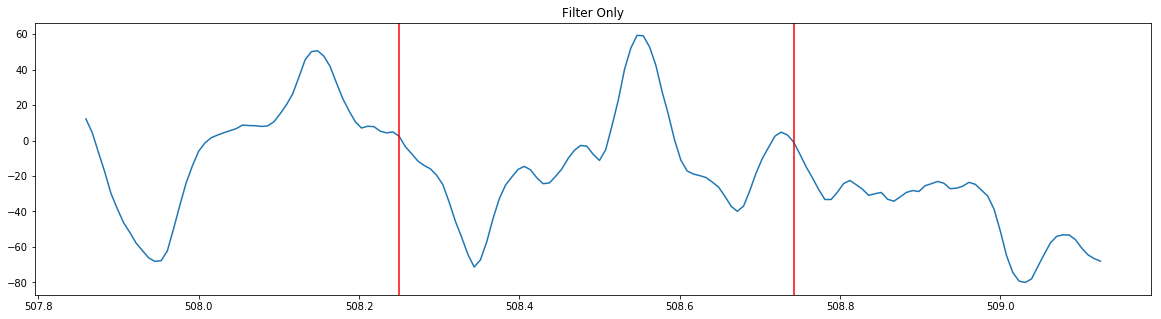

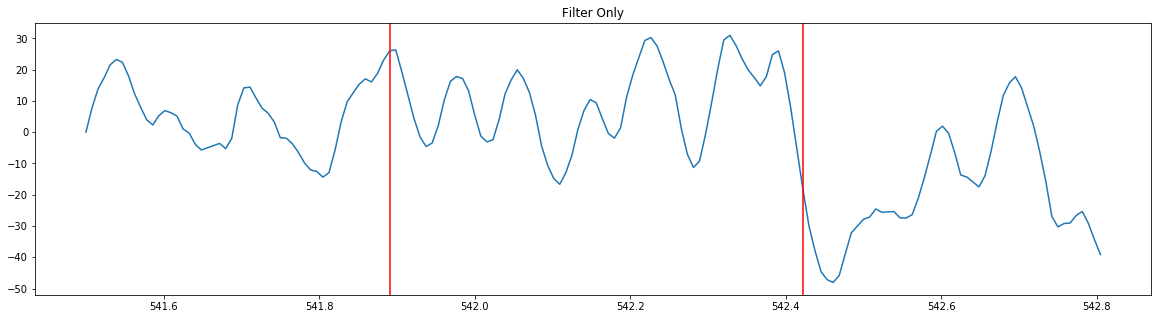

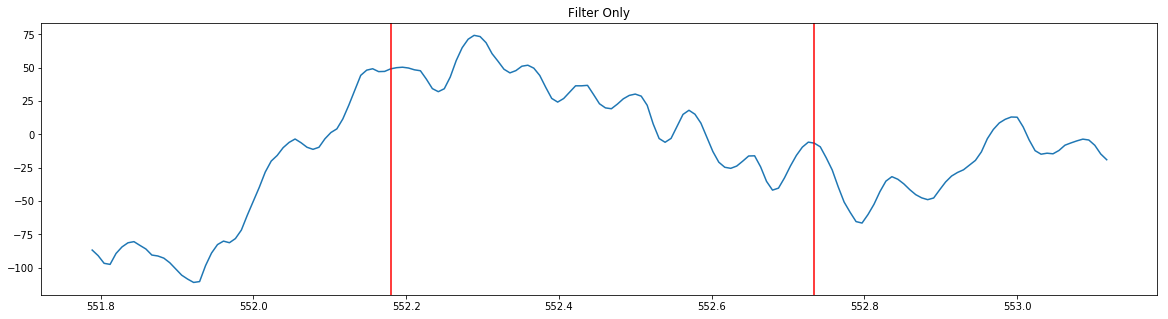

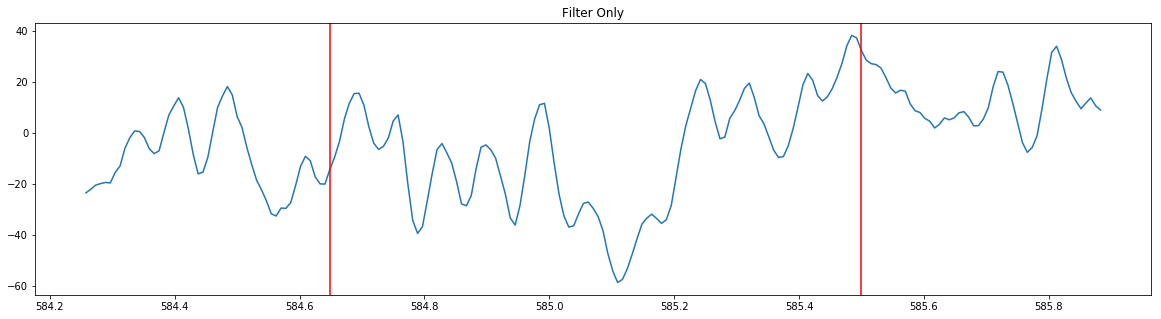

In [340]:
print("Legend\n===============\nGREEN - Spindles found by MP \nRED - Spindles found through filtering\n===============")
covering = []
for index, i in enumerate(mp_spindles):
    low = abs(np.array(filt_spindles)[:,0] - i[0])
    if low[np.where(low == min(low))[0][0]] <= 0.5:
        covering.append([np.where(low == min(low))[0][0], index]) # [filt, mp]
covering = np.array(covering)
for index, i in enumerate(mp_spindles):
    plt.figure(figsize=((20,5)))
    if index in covering[:, 1]:
        where = np.where(covering[:, 1] == index)[0][0]
        l = ((np.array(filt_spindles[covering[where][0]])*Fs).astype('int'), (np.array(mp_spindles[covering[where][1]])*Fs).astype('int'))
        plt.plot(t[l[0][0]-50:l[0][1]+50], s[l[0][0]-50:l[0][1]+50])
        plt.axvline(t[l[0][0]], c='r')
        plt.axvline(t[l[0][1]], c='r')
        plt.axvline(t[l[1][0]], c='g')
        plt.axvline(t[l[1][1]], c='g')
        plt.title('Filter & MP')
    else:
        l = (np.array(i)*Fs).astype('int')
        plt.plot(t[l[0]-50:l[1]+50], s[l[0]-50:l[1]+50])
        plt.axvline(t[l[0]], c='g')
        plt.axvline(t[l[1]], c='g')
        plt.title('MP Only')
    plt.show()
for index, i in enumerate(filt_spindles):
    if index in covering[:, 1]:
        pass
    else:
        plt.figure(figsize=((20,5)))
        l = (np.array(i)*Fs).astype('int')
        plt.plot(t[l[0]-50:l[1]+50], s[l[0]-50:l[1]+50])
        plt.axvline(t[l[0]], c='r')
        plt.axvline(t[l[1]], c='r')
        plt.title('Filter Only')
        plt.show()